In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
# utils
def onehot(idx, N): # hacky. i know...
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def sample(x, logits):
    # or could use gumbel trick
    p = softmax(logits)
    return np.random.choice(x, p=p)

In [3]:
class Env():
    def __init__(self, n_states, n_actions):
        """
        Args:
            n_states (int): the number of states
            n_actions (int): the number of action
        """
        self.n_states = n_states
        
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)
        

        # each action move from state(i) to state(j) with probability close to 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, self.n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)

    def new_task(self):
        self.R = onehot(np.random.randint(0, self.n_states), self.n_states)

In [4]:
env = Env(5,3)

In [105]:
class MultiStepMDP():
    def __init__(self, mdp, k):
        self.k = k
        self.mdp = mdp
        
        self.S = mdp.S
        self.A = list(itertools.product(*[mdp.A for _ in range(k)]))
        
    def step(self, state, action):
        assert len(self.A[action]) == self.k
        r = 0
        states = []
        for a in self.A[action]:
            state, r = self.mdp.step(state, a)
            r += r
            states.append((state, a))
        return states[-1][0], r, states
    
    def reset(self):
        return self.mdp.reset()
    
    def rnd_policy(self, s, *args):
        return np.random.choice(range(len(self.A)))

In [96]:
class TabularSARSA():
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.gamma = 0.999
        self.lr = 0.1

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(np.arange(self.n_actions), self.qs[s, ...])
        # should change to epsilon greedy or entropy regularised
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!
        self.qs -= 1e-4 * self.qs  # entropy regularisation

In [101]:
def play_episode(env, player, len_episode, return_visited_state_actions=False):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    
    visited_state_actions = []
    
    # play an episode
    for _ in range(len_episode):
        a = player(s, r)
        s, r, ss = env.step(s, a)
        total_r += r
        
        visited_state_actions += ss
        
    if return_visited_state_actions:
        return total_r, visited_state_actions
    else:
        return total_r

In [98]:
n_states = 16
n_actions = 3
k = 5

In [57]:
env = Env(n_states, n_actions)
player = TabularSARSA(n_states, n_actions)
np.var([play_episode(env, env.rnd_policy, 100) for _ in range(500)])

13.840416000000001

In [29]:
new_env = MultiStepMDP(env, k)
new_player = TabularSARSA(n_states, len(new_env.A))
np.var([play_episode(new_env, new_env.rnd_policy, 100//k) for _ in range(500)])

0.707504

In [30]:
variances = []
for k in range(1, 10):
    print('\r{}'.format(k))
    new_env = MultiStepMDP(env, k)
    new_player = TabularSARSA(n_states, len(new_env.A))
    variances.append(np.var([play_episode(new_env, new_env.rnd_policy, 100//k) for _ in range(100)]))

1
2
3
4
5
6
7
8
9


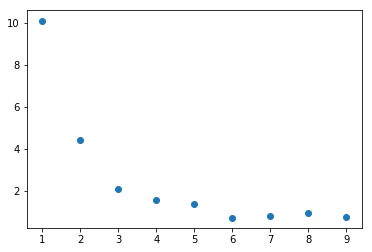

In [31]:
plt.scatter(range(1, 10), variances)

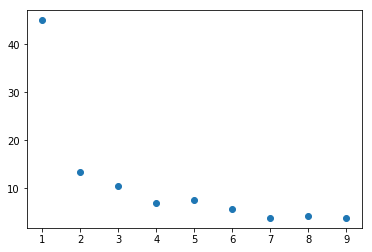

In [32]:
n_states = 8
n_actions = 2

env = Env(n_states, n_actions)
player = TabularSARSA(n_states, n_actions)

variances = []
for k in range(1, 10):
#     print('\r{}'.format(k))
    new_env = MultiStepMDP(env, k)
    new_player = TabularSARSA(n_states, len(new_env.A))
    variances.append(np.var([play_episode(new_env, new_env.rnd_policy, 100//k) for _ in range(100)]))
    
plt.scatter(range(1, 10), variances)

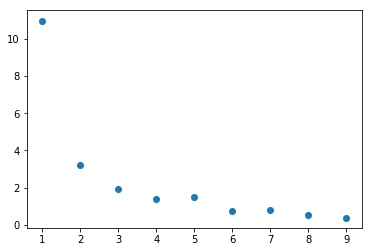

In [106]:
n_states = 64
n_actions = 3

env = Env(n_states, n_actions)
player = TabularSARSA(n_states, n_actions)

variances = []
for k in range(1, 10):
#     print('\r{}'.format(k))
    new_env = MultiStepMDP(env, k)
    new_player = TabularSARSA(n_states, len(new_env.A))
    variances.append(np.var([play_episode(new_env, new_env.rnd_policy, 100//k) for _ in range(100)]))
    
plt.scatter(range(1, 10), variances)

In [143]:
def collect_visitation_counts(env, player, k):
    visitation_counts = np.zeros((n_states, n_actions))
    for _ in range(1000):
        rs, sas = play_episode(new_env, new_env.rnd_policy, 100//k, return_visited_state_actions=True)

        visitation_counts[tuple(zip(*sas))] += 1

    return visitation_counts

5.242779605283963

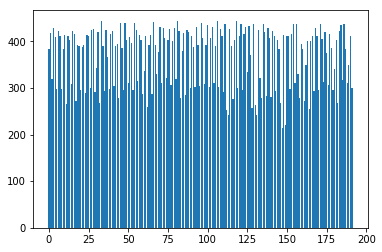

In [170]:
n_states = 64
n_actions = 3
k=1

env = Env(n_states, n_actions)
player = TabularSARSA(n_states, n_actions)

new_env = MultiStepMDP(env, k)
new_player = TabularSARSA(n_states, len(new_env.A))


state_action_visitations = collect_visitation_counts(new_env, new_player, k)
_ = plt.bar(range(n_states*n_actions), state_action_visitations.ravel())
entropy(state_action_visitations)

5.2440018948782825

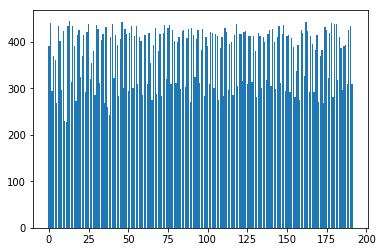

In [169]:
k=3

new_env = MultiStepMDP(env, k)
new_player = TabularSARSA(n_states, len(new_env.A))

state_action_visitations = collect_visitation_counts(new_env, new_player, k)
_ = plt.bar(range(n_states*n_actions), state_action_visitations.ravel())
entropy(state_action_visitations)

5.244052242637402

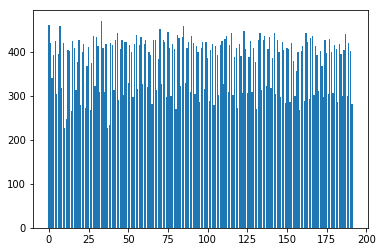

In [168]:
k=5

new_env = MultiStepMDP(env, k)
new_player = TabularSARSA(n_states, len(new_env.A))

state_action_visitations = collect_visitation_counts(new_env, new_player, k)
_ = plt.bar(range(n_states*n_actions), state_action_visitations.ravel())
entropy(state_action_visitations)

5.244233065511663

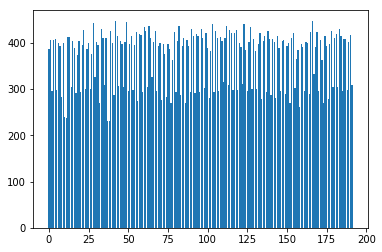

In [167]:
k=7

new_env = MultiStepMDP(env, k)
new_player = TabularSARSA(n_states, len(new_env.A))

state_action_visitations = collect_visitation_counts(new_env, new_player, k)
_ = plt.bar(range(n_states*n_actions), state_action_visitations.ravel())
entropy(state_action_visitations)

In [166]:
def entropy(counts):
    p = counts / np.sum(counts)
    return np.sum(- p * np.log(p))